In [1]:
import sys
# sys.path.insert(0, '../../')
import rasterio
import numpy as np
from pathlib import Path
import rioxarray

In [2]:
import warnings
import time
import os

# RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
#     CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
#     GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
#     AWS_NO_SIGN_REQUEST="YES",
#     GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
#     GDAL_SWATH_SIZE="200000000",
#     VSI_CURL_CACHE_SIZE="200000000",
# )
# os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T

import geopandas as gpd
import dask_geopandas

import pystac_client
import planetary_computer as pc

import shapely.geometry

## Manually extract RGB and NIR patches around north berkeley

In [3]:
from shapely.geometry import Point
berkeley = Point(-122.24055786132824,37.90587960532352)

EPSG:32610
256 420.72165626026947
(3, 256, 420)
torch.Size([3, 256, 256]) <class 'torch.Tensor'>


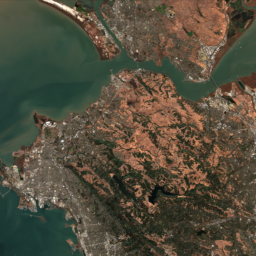

In [4]:
import torchvision.transforms as T
from rasterio.enums import Resampling

side_length = 50000
side_px=256
image_rgb = None
url_rgb = 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/S/EH/2019/11/21/S2B_MSIL2A_20191121T185659_N0212_R113_T10SEH_20201003T184646.SAFE/GRANULE/L2A_T10SEH_A014153_20191121T190140/IMG_DATA/R10m/T10SEH_20191121T185659_TCI_10m.tif?st=2022-12-02T19%3A55%3A09Z&se=2022-12-04T03%3A55%3A09Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-03T07%3A41%3A47Z&ske=2022-12-10T07%3A41%3A47Z&sks=b&skv=2021-06-08&sig=kRpiQu118eJfJjF4LaiJOH7Ktp/QLt3B8m0KwcBIvlc%3D'
url_nir = 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/S/EH/2019/11/21/S2B_MSIL2A_20191121T185659_N0212_R113_T10SEH_20201003T184646.SAFE/GRANULE/L2A_T10SEH_A014153_20191121T190140/IMG_DATA/R10m/T10SEH_20191121T185659_B08_10m.tif?st=2022-11-27T23%3A55%3A49Z&se=2022-11-29T07%3A55%3A49Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-11-28T21%3A44%3A55Z&ske=2022-12-05T21%3A44%3A55Z&sks=b&skv=2021-06-08&sig=R4Hwm2SxloOG%2BVIj53DhSUCcv0QF/rSOrA8xLBhee5U%3D'
postprocess = T.Compose ([T.Resize(side_px), 
                         T.CenterCrop((side_px,side_px))])

to_pil = T.ToPILImage()

aoi_si = None
aspect_ratio = 1.

buf_perc = 0.1

with rasterio.Env():
    with rasterio.open(url_rgb, "r") as f:
        
        point_geom = rasterio.warp.transform_geom("epsg:4326", f.crs.to_string(), berkeley)
        print(f.crs.to_string())
        #Convert the point to a shape
        point_shape = shapely.geometry.shape(point_geom)
        #Create a square out of it with side_length = buffer*2
        radius = side_length/2 
        mask_shape = point_shape.buffer(radius).envelope
        mask_geom = shapely.geometry.mapping(mask_shape)
        
        # mask_gdf = gpd.GeoDataFrame(geometry=mask_geom, crs=f.crs.to_string())  
        # mask_gdf
        # mask_geom
        # rds = rioxarray.open_rasterio(f) #, masked=True)
        try:

            #Outer crop
            aoi_si = rioxarray.open_rasterio(f).rio.clip([mask_geom], from_disk=True)

            aspect_ratio = aoi_si.shape[2]/aoi_si.shape[1]

            new_height = side_px
            new_width = aspect_ratio * new_height
            
            print(new_height, new_width)

            #downsample raster                                    # (height, width)
            aoi_si = aoi_si.rio.reproject(aoi_si.rio.crs, shape=(int(new_height), int(new_width)), resampling=Resampling.bilinear)

            # image_rgb.sel(band=1).plot.imshow()
            # image_rgb.plot.imshow()
            print(aoi_si.shape)
            # image_rgb.plot.imshow()
            #Convert to torch
            # RGB
            # t = torch.from_numpy(aoi_si.values).float()
            
            ## NIR
            t = torch.from_numpy(aoi_si.values.astype(np.uint8))
            
            # postprocess = T.Compose ([T.CenterCrop((t.shape[1])),
            #                          T.Resize(side_px)])
            # t = T.CenterCrop(size=(t.shape[1]))(t)
            # t = T.Resize(size=side_px, antialias=True)(t)
            # display1 = to_pil(t)
            t = T.CenterCrop(size=(t.shape[1]))(t)
            display2 = to_pil(t)
            # t = F.resize(t, (1024,1024))
            # t = postprocess(t)
            #otherwise images dont display properly
            #but uint8 conversion has already taken care of this downresolution
            # t /= 255 
            print(t.shape, type(t))
#             #only for display
           
            # display1.show("Before CenterCrop")
            display2.show("After CenterCrop")
            
        except ValueError as e:
            print("Couldnt open URL ({:} or requested grid doesnt overlap)")


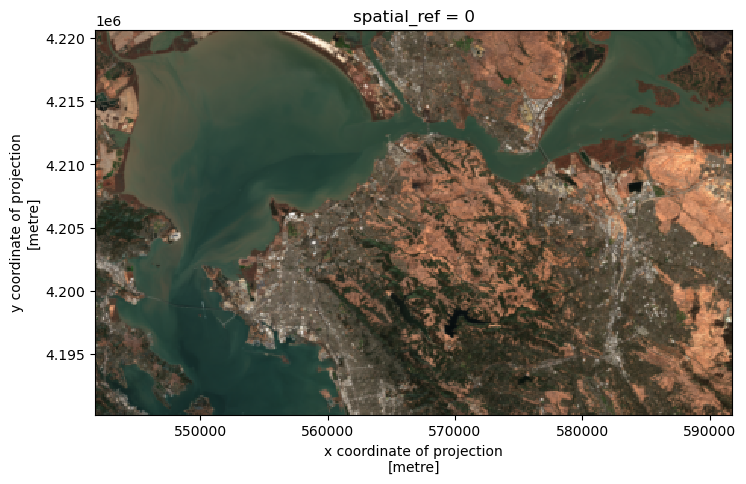

In [5]:
aoi_si.plot.imshow(size=5, aspect=aspect_ratio)

In [6]:
aoi_si.rio.resolution(), aoi_si.rio.height,  aoi_si.values.shape

((119.07142857142857, -118.8671875), 256, (3, 256, 420))

In [15]:
aoi_si

<xarray.DataArray (band: 3, y: 256, x: 420)>
array([[[ 72,  63,  68, ...,  41,  41,  32],
        [ 66,  71,  76, ...,  45,  33,  28],
        [ 57,  69,  81, ...,  56,  42,  34],
        ...,
        [ 57,  56,  58, ...,  67,  62,  86],
        [ 68,  46,  48, ..., 144, 109,  76],
        [ 60,  53,  45, ..., 177, 159,  72]],

       [[ 68,  51,  48, ...,  34,  33,  27],
        [ 57,  57,  58, ...,  35,  29,  25],
        [ 60,  52,  62, ...,  43,  34,  28],
        ...,
        [ 55,  55,  56, ...,  52,  49,  64],
        [ 57,  45,  46, ...,  99,  78,  58],
        [ 54,  50,  43, ..., 119, 108,  53]],

       [[ 51,  39,  36, ...,  29,  28,  24],
        [ 43,  43,  44, ...,  29,  25,  22],
        [ 46,  40,  48, ...,  34,  29,  23],
        ...,
        [ 44,  45,  46, ...,  35,  33,  45],
        [ 45,  35,  36, ...,  73,  57,  41],
        [ 41,  38,  33, ...,  89,  80,  38]]], dtype=uint8)
Coordinates:
  * x            (x) float64 5.418e+05 5.419e+05 ... 5.916e+05 5.917e+05
  * y            (y) float64 4.221e+06 4.22e+06 4.22e+06 ... 4.19e+06 4.19e+06
  * band         (band) int64 1 2 3
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     255

## Open a single env raster to match with

In [7]:
local_path = "bio_11_USA.tif"
s3_raster_path = "s3://datasets-sdm/geoLifeCLEF/rasters/bdticm/bdticm_USA.tif"

env_raster = None

with rasterio.Env():
    with rasterio.open(s3_raster_path, "r") as f:
            # rds = rioxarray.open_rasterio(f, bbox=mask_geom['coordinates'], crop=True)
            env_raster = rioxarray.open_rasterio(f,masked=True)
            
env_raster

<xarray.DataArray (band: 1, y: 13440, x: 28800)>
[387072000 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -125.0 -125.0 -125.0 -125.0 ... -65.01 -65.0 -65.0
  * y            (y) float64 50.0 50.0 49.99 49.99 ... 22.01 22.0 22.0 22.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  112467
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   nan
    scale_factor:        1.0
    add_offset:          0.0

## Let's try to open, crop and reproject ENV raster in one shot

In [10]:
# cropped_env_raster = aoi_env.rio.reproject_match(aoi_si)
%time
cropped_env_raster = env_raster.rio.reproject_match(aoi_si)


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.34 µs


In [11]:
%time
t_env = torch.from_numpy(cropped_env_raster.values.astype(np.uint8))
t_env = T.CenterCrop(size=(t_env.shape[1]))(t_env)
display1 = to_pil(t_env)

print(t_env.shape, type(t_env))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs
torch.Size([1, 256, 256]) <class 'torch.Tensor'>


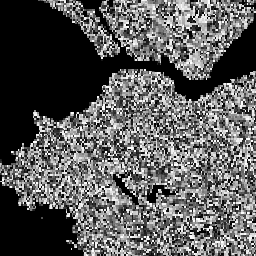

In [19]:
display1.show("After CenterCrop")

In [109]:
import gc
del cropped_env_raster
gc.collect()

147

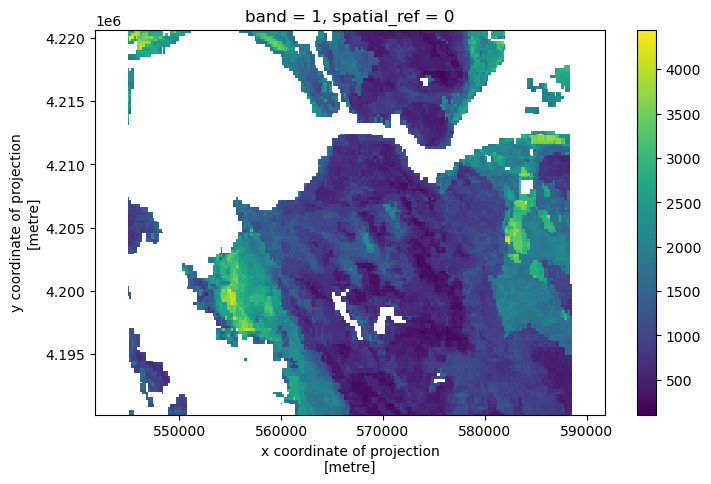

In [104]:
cropped_env_raster[0].plot.imshow(size=5,aspect=aspect_ratio)

## Same, but with Patch Extractor

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from environmental_raster import PatchExtractor

In [4]:
env_extractor = PatchExtractor(s3_path, side_len_m=50000, side_px=512, out_dtype="float")

NameError: name 's3_path' is not defined